# Clusterizacion por K-Means
Para el algoritmo no supervizado voy a optar por usar el algoritmo de k-means donde dividimos la data en k clusters que comparten determinadas caracteristicas, este algoritmo es rapido y escalable sin mencionar que se puede enfocar muy bien al problema, dado que al identificar grupos de clientes con características similares (ej. clientes puntuales vs. morosos frecuentes), se pueden personalizar estrategias comerciales, de riesgo o cobranza.

In [8]:
import polars as pl

# Cargar los datos
train = pl.read_csv("files/output/train.csv")

# Verificar estructura
print(train.shape)
print(train.columns)


(1148573, 88)
['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'INGRESO_POR_PE

Se deben seleccionar las variables a utilizar en la clusterizacion de la data, no se deben seleccionar todas las variables debido a que cuando tienes muchas variables en un modelo, especialmente si algunas no son importantes, las diferencias entre las personas se vuelven más difíciles de ver. Imagina que tienes un mapa con muchas calles y caminos, pero muchos de esos caminos no llevan a ningún lugar importante.

Las variables deben abarcar aspectos demográficos, socioeconómicos y financieros para obtener clusters significativos y representativos. K-Means agrupa a las personas en función de la similitud de sus características, por lo que es esencial tener una diversidad de variables que describan el comportamiento financiero desde diferentes ángulos.

Dado que ya realizamos todo el preprocesamiento de la data. 

Para el algoritmo de K-means lo primero que debemos hacer es escalar las variables numéricas, ya que K-Means es sensible a la escala de las variables. Voy a utilizar StandardScaler de scikit-learn para normalizar los datos.

In [11]:
from sklearn.preprocessing import StandardScaler

# Se normalizan unicamente las variables numericas
numeric_columns = [
    "CNT_CHILDREN", "REGION_POPULATION_RELATIVE", "AMT_INCOME_TOTAL", "AMT_CREDIT", 
    "AMT_ANNUITY", "CNT_PAYMENT", "AMT_APPLICATION", "AMT_GOODS_PRICE_right", 
    "INGRESO_POR_PERSONA", "CONVERTIDO_DAYS_EMPLOYED", "CONVERTIDO_DAYS_BIRTH"
]

# Convertir a pandas para aplicar StandardScaler
train_df_pandas = train.select(numeric_columns).to_pandas()
scaler = StandardScaler()
train_df_normalized = scaler.fit_transform(train_df_pandas)

# Convertir de nuevo a polars
train_df_normalized = pl.DataFrame(train_df_normalized, schema=numeric_columns)

# Aqui verifico si no hubo problemas en la normalizacion
print(train_df_normalized.head())


shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ CNT_CHILD ┆ REGION_PO ┆ AMT_INCOM ┆ AMT_CREDI ┆ … ┆ AMT_GOODS ┆ INGRESO_P ┆ CONVERTID ┆ CONVERTI │
│ REN       ┆ PULATION_ ┆ E_TOTAL   ┆ T         ┆   ┆ _PRICE_ri ┆ OR_PERSON ┆ O_DAYS_EM ┆ DO_DAYS_ │
│ ---       ┆ RELATIVE  ┆ ---       ┆ ---       ┆   ┆ ght       ┆ A         ┆ PLOYED    ┆ BIRTH    │
│ f64       ┆ ---       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ -0.719247 ┆ -0.024226 ┆ 0.643324  ┆ -0.286705 ┆ … ┆ 0.492681  ┆ 2.773273  ┆ -0.960708 ┆ -1.56915 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ -0.719247 ┆ -0.024226 ┆ 0.643324  ┆ -0.286705 ┆ … ┆ 0.492681  ┆ 2.773273  

### Determinar numero de clusters (K)
Voy a utilizar el metodo del codo para determinar el numero optimo de clusters que deberia tener K-means, el metodo del codo se basa en determinar de manera grafica la ganancia que obtengo con forme aumento el numero de clusters (cuando la ganancia tiende a dejar de ser significativa se genera un punto de inflexion en la grafica o un "codo"), el numero donde se genera el codo es el numero optimo de clusters

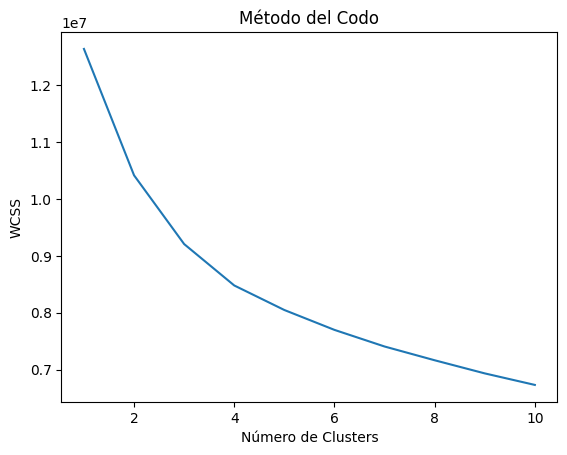

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculamos el WCSS (Ganancia) para diferentes valores de k
wcss = []
for i in range(1, 11):  # Probar con 1 a 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(train_df_normalized)
    wcss.append(kmeans.inertia_)

# Graficar el WCSS
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()


Con el metodo del codo podemos ver que hay puntos de inflexion en 2,3 y 4. 

Voy a optar por utilizar 3 como numero optimo de clusters

In [ ]:
from sklearn.cluster import KMeans
from tqdm import tqdm  # Importar tqdm

# Aplicar K-Means con el número óptimo de clusters
optimal_k = 3

# Usamos tqdm aunque sea solo una iteración para mostrar barra de progreso, no influye en nada en el codigo
for _ in tqdm(range(1), desc=f"Entrenando KMeans con {optimal_k} clusters"):
    # init='k-means++' asegura que se elijan los centroides de la manera mas inteligente, max_iter=300 es el numero maximo de iteraciones
    # n_init=10 El número de veces que se ejecutará el algoritmo con diferentes centroides iniciales. 
    # De todas las ejecuciones, se escoge la mejor (la de menor WCSS).
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(train_df_normalized)

# Obtener las etiquetas de los clusters
train_df_pandas['cluster'] = kmeans.labels_

# Ver los primeros registros con sus etiquetas de cluster
print(train_df_pandas[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'cluster']].head())


Entrenando KMeans con 3 clusters: 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  cluster
0           0.0           12.2185   12.915581        0
1           0.0           12.2185   12.915581        0
2           0.0           12.2185   12.915581        0
3           0.0           12.2185   12.915581        0
4           0.0           12.2185   12.915581        0


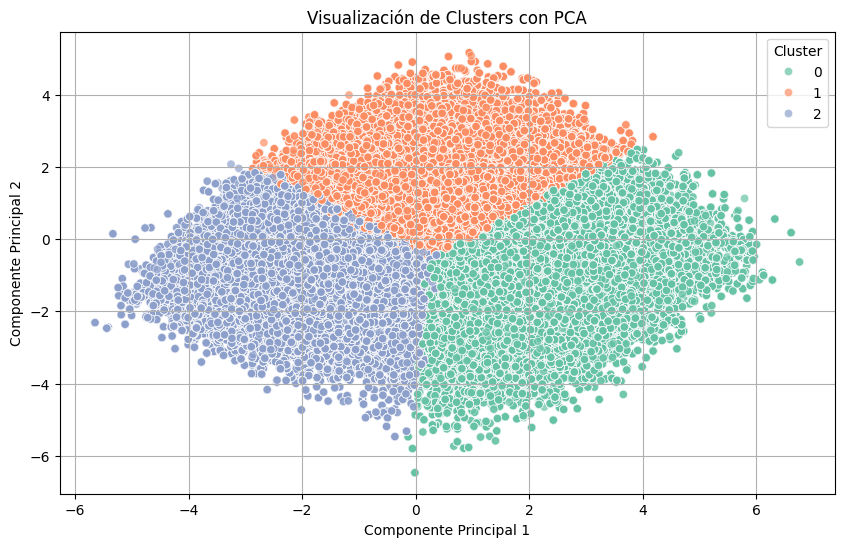

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducimos los datos a 2 componentes principales para visualización
train_df=train_df_pandas
pca = PCA(n_components=2)
pca_components = pca.fit_transform(train_df_normalized)

# Creamos un DataFrame con los resultados
pca_df = train_df.copy()
pca_df["PCA1"] = pca_components[:, 0]
pca_df["PCA2"] = pca_components[:, 1]

# Graficamos los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x="PCA1",
    y="PCA2",
    hue="cluster",
    palette="Set2",
    alpha=0.7
)
plt.title("Visualización de Clusters con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


Ya tenemos la clusterizacion de la poblacion pero el modelo K-means separa la poblacion en grupos pero no me dice en ningun momento cuales son los posibles grupos, para ello es necesario desglozar los estadisticos de cada columna segmentado por cluster, se crea un archivo csv que contiene los estadisticos de cada cluster y con este se construye un perfil de cada persona.

In [30]:
import os
# Estadísticas descriptivas por cluster
cluster_description = train_df.groupby('cluster').describe()
print(cluster_description)

# Crear el directorio si no existe
os.makedirs("files/output", exist_ok=True)

# Calcular estadísticas por cluster
cluster_description = train_df.groupby("cluster").describe()

# Exportar a CSV
#cluster_description.to_csv("files/output/cluster_description.csv", index=False)

#print("Archivo guardado en: files/output/cluster_description.csv")


        CNT_CHILDREN                                               \
               count      mean       std  min  25%  50%  75%  max   
cluster                                                             
0           281279.0  0.346343  0.603729  0.0  0.0  0.0  1.0  2.0   
1           447567.0  0.449499  0.658218  0.0  0.0  0.0  1.0  2.0   
2           419727.0  0.635048  0.733368  0.0  0.0  0.0  1.0  2.0   

        REGION_POPULATION_RELATIVE                                          \
                             count      mean       std       min       25%   
cluster                                                                      
0                         281279.0  0.019645  0.010381  0.001276  0.010032   
1                         447567.0  0.019300  0.010586  0.001276  0.010006   
2                         419727.0  0.018375  0.009371  0.001276  0.010006   

                                     AMT_INCOME_TOTAL                       \
              50%       75%      max  

Con esta in